In [18]:
from time import time
import numpy, os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2

#Path to the root image directory containing sub-directories of images
path="dataset/"

data_slice = [70,195,78,172] # [ ymin, ymax, xmin, xmax]
# to extract the ‘interesting’ part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimention
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

n_sample = 0 #Initial sample count
label_count = 0 #Initial label count
n_classes = 0 #Initial class count

#PCA Component 
n_components = 7

Image dimension after resize (h,w) : 50 37


In [19]:
#Flat image Feature Vector
X=[]
#Int array of Label Vector
Y=[]

target_names = [] #Array to store the names of the persons

for directory in os.listdir(path):
    for file in os.listdir(path+directory):
        img=cv2.imread(path+directory+"/"+file)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        img=cv2.resize(img, (w,h))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        featurevector=numpy.array(img).flatten()
        X.append(featurevector)
        Y.append(label_count)
        n_sample = n_sample + 1
    target_names.append(directory)
    label_count=label_count+1


print("Samples :", n_sample)
print("Class :", target_names)
n_classes = len(target_names)

Samples : 30
Class : ['Thuy']


In [20]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and teststing set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, len(X_train)))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("\n")
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 7 eigenfaces from 22 faces
done in 0.008s


Projecting the input data on the eigenfaces orthonormal basis
done in 0.001s


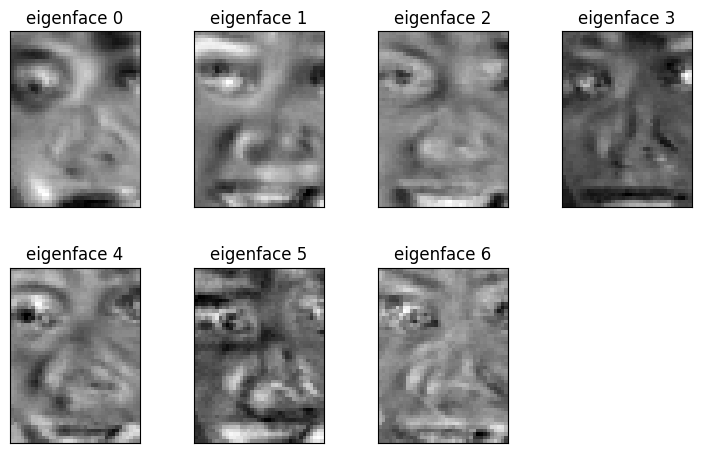

In [21]:
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_components):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)


In [22]:
###############################################################################
# Train a SVM classification model
try:
    # Train a SVM classification model
    print("\n")
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=5)
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))

    print("\n")
    print("Best estimator found by grid search : ")
    print(clf.best_estimator_)

    # Quantitative evaluation of the model quality on the test set
    print("\n")
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print(clf.score(X_test_pca, y_test))
    print("done in %0.3fs" % (time() - t0))

except Exception as e:
    print(f"An error occurred: {e}")



Fitting the classifier to the training set
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..............C=1000.0, gamma=0.0001;, score=nan total time=   0.0s
[CV 2/5] END ..............C=1000.0, gamma=0.0001;, score=nan total time=   0.0s
[CV 3/5] END ..............C=1000.0, gamma=0.0001;, score=nan total time=   0.0s
[CV 4/5] END ..............C=1000.0, gamma=0.0001;, score=nan total time=   0.0s
[CV 5/5] END ..............C=1000.0, gamma=0.0001;, score=nan total time=   0.0s
[CV 1/5] END ..............C=1000.0, gamma=0.0005;, score=nan total time=   0.0s
[CV 2/5] END ..............C=1000.0, gamma=0.0005;, score=nan total time=   0.0s
[CV 3/5] END ..............C=1000.0, gamma=0.0005;, score=nan total time=   0.0s
[CV 4/5] END ..............C=1000.0, gamma=0.0005;, score=nan total time=   0.0s
[CV 5/5] END ..............C=1000.0, gamma=0.0005;, score=nan total time=   0.0s
[CV 1/5] END ...............C=1000.0, gamma=0.001;, score=nan total time=   0.0s
[C

ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py", line 747, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class


In [ ]:
print("\nClassification Report : ")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Classification Report : 
              precision    recall  f1-score   support

        Cong       1.00      1.00      1.00         7
         hai       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix : 
[[7 0]
 [0 8]]


In [ ]:
###############################################################################
# Prediction of user based on the model

test = []
testImage = "test/a (1).jpg"


testImage=cv2.imread(testImage)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
testImage=cv2.resize(testImage, (w,h))
testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
testImageFeatureVector=numpy.array(testImage).flatten()
test.append(testImageFeatureVector)
testImagePCA = pca.transform(test)
testImagePredict=clf.predict(testImagePCA)


print ("Predicted Name : " + target_names[testImagePredict[0]])


Predicted Name : Cong


In [ ]:
path_testdata = "test/"

for file in os.listdir(path_testdata):
    test = []

    filename=path_testdata + file    
    testImage=cv2.imread(filename)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
    testImage=cv2.resize(testImage, (w,h))
    testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
    testImageFeatureVector=numpy.array(testImage).flatten()
    
    test.append(testImageFeatureVector)
    testImagePCA = pca.transform(test)
    testImagePredict=clf.predict(testImagePCA)

    print ("File Source : " + filename)
    print ("Predicted Name : " + target_names[testImagePredict[0]] + "\n")

File Source : test/a (1).jpg
Predicted Name : Cong

File Source : test/a (1).png
Predicted Name : Cong

File Source : test/a (2).jpg
Predicted Name : Cong

File Source : test/a (3).jpg
Predicted Name : hai

File Source : test/a (3).png
Predicted Name : Cong

File Source : test/a (4).jpg
Predicted Name : hai

File Source : test/a (4).png
Predicted Name : Cong

File Source : test/a (5).jpg
Predicted Name : hai

File Source : test/a (5).png
Predicted Name : hai

File Source : test/a (6).jpg
Predicted Name : Cong

File Source : test/c (Medium).jpg
Predicted Name : Cong

File Source : test/c.jpg
Predicted Name : Cong



In [ ]:
#CAMERA
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

cap.set(3,640)
cap.set(4,480)

while(True):
    # Capture frame-by-frame
    test = []
    face = []
    ret, frame = cap.read()
    xv, yv, cv = frame.shape
    if ret == True :
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,wf,hf) in faces:
            cy, cx = y + (hf//2), x + (wf//2)
            max_len = max(max(hf//2,wf//2), 125)
            
            if (x - max_len) <= 0 or (x + max_len) >= xv or (y - max_len) <= 0 or (y + max_len) >= yv :
                continue
            face_crop = (frame[cy-max_len:cy+max_len, cx-max_len:cx+max_len])
            face_crop = face_crop[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
            
            testImage = cv2.resize(face_crop, (w,h))
            cv2.imshow('face',testImage)
            
            testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
            testImageFeatureVector=numpy.array(testImage).flatten()
            test.append(testImageFeatureVector)
            testImagePCA = pca.transform(test)
            testImagePredict=clf.predict(testImagePCA)
            
            # create box on detected face
            frame = cv2.rectangle(frame,(x,y),(x+wf,y+hf),(255,51,255),2)
            frame = cv2.rectangle(frame,(x,y+hf),(x+wf,y+hf+30),(255,51,255),-1)
            # print label name on image
            cv2.putText(frame, "Name : " + target_names[testImagePredict[0]], (x + x//10, y+hf+20), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        cv2.imshow('frame',frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


Processing: ./test/a (5).jpg
Hog + SVM Execution time: 0.20233774185180664
Predicted Name : Son


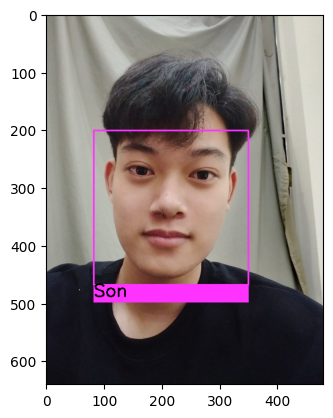

In [ ]:
# IMAGE
import time
import dlib
import matplotlib.pyplot as plt
# Đọc ảnh đầu vào
fileName = './test/a (5).jpg'
frame = cv2.imread(fileName)
# Khai báo việc sử dụng các hàm của dlib
hog_face_detector = dlib.get_frontal_face_detector()

# Thực hiện xác định bằng HOG và SVM
start = time.time()
faces_hog = hog_face_detector(frame, 1)
end = time.time()
print("Processing:",fileName)
print("Hog + SVM Execution time: " + str(end-start))
test = []
# Vẽ một đường bao xung quanh các khuôn mặt được xác định ra bởi HOG + SVM
for face in faces_hog:
  x = face.left()
  y = face.top()
  wi = face.right() - x
  he = face.bottom() - y
  cv2.rectangle(frame, (x,y), (x+wi,y+he), (255,51,255), 2)
  cv2.rectangle(frame,(x,y+he),(x+wi,y+he+30),(255,51,255),-1)
  fileName=cv2.imread(fileName)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
  fileName=cv2.resize(fileName, (w,h))
  fileName=cv2.cvtColor(fileName, cv2.COLOR_BGR2GRAY)
  fileNameFeatureVector=numpy.array(fileName).flatten()
  test.append(fileNameFeatureVector)
  fileNamePCA = pca.transform(test)
  fileNamePredict=clf.predict(fileNamePCA)
  
cv2.putText(frame, target_names[fileNamePredict[0]], (x, y+he+20),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
print ("Predicted Name : " + target_names[fileNamePredict[0]])

plt.imshow(frame)
cv2.waitKey(0)
cv2.destroyAllWindows()